# Lab Assignment Five: Wide and Deep Networks
Name: Marc Pham, Alonso Gurrola

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from scipy.optimize import minimize_scalar, fmin_bfgs
from numpy.linalg import pinv
from sklearn.metrics import accuracy_score
from scipy.special import expit
import copy
import time
from numpy import ma # (masked array) this has most numpy functions that work with NaN data.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, FeatureSpace
from tensorflow.keras.metrics import FBetaScore, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import graphviz
import pydot

warnings.filterwarnings('ignore')

# 1. Preparation

The data, funded by the Instituto Politécnico de Portalegre on April 23, 2021, aims to identify students at risk of dropping out of higher education.  The dataset includes 4,424 students who are classified as dropouts, current enrollees, or graduates.  For each student, the data includes 37 total features, including demographic features (e.g., race and gender) and economic factors (e.g., the inflation rate and unemployment rate at the time of their application) that may influence their likelihood for dropping out.  The funders’ original goal was to use machine learning techniques to detect which students are at risk of dropping out and implement targeted interventions, such as scholarships, to support these students.

The end goal of analyzing this dataset is to classify a student as a potential dropout or an enrollee/graduate based on economic factors and each student’s demographic features.  The results can help university admissions offices and government agencies determine which groups of students need additional support to get through higher education.  However, it is important to note that third parties could use these results to choose which students to accept or deny from a university.  Keeping this in mind, the final classification algorithm should not be trained on race since the Supreme Court banned the use of race in college admissions.

For the algorithm to be successful, we need the algorithm to accurately classify which students are dropping out.  It is less important if the model inaccurately predicts an Enrollee as a Graduate or vice versa.  As a result, we should use metrics like precision and recall to measure how well the algorithm does at classifying dropouts.  For our algorithm, recall measures the percentage of actual dropouts that the algorithm correctly classifies.  Our recall should be as close as possible to 100% to minimize the probability of missing any students at risk of dropping out.  Precision measures the percentage of students predicted to drop out who are actual dropouts.  Low precision means we are giving additional resources to many students not at risk of dropping out, while high precision means that resources are used effectively.  Although high precision is ideal, it would be acceptable to have lower precision, like 70%, if it significantly increases recall.  The balance between precision and recall will depend on how much financial flexibility institutions have.

In [187]:
df = pd.read_csv('data.csv', sep=';')
df['Target'].replace({'Enrolled' : 'Non-Dropout', 'Graduate' : 'Non-Dropout'}, inplace=True)
counts = np.unique(df['Target'],return_counts=True) # Used in another section
df = df.rename(columns = {
    'Daytime/evening attendance\t' : 'Daytime/evening attendance',               
    'Nacionality': 'Nationality'})
df['Target'].replace({'Dropout' : 1, 'Non-Dropout' : 0}, inplace=True)

Sources: [Dataset](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)

M.V.Martins, D. Tolledo, J. Machado, L. M.T. Baptista, V.Realinho. (2021) "Early prediction of student’s performance in higher education: a case study" Trends and Applications in Information Systems and Technologies, vol.1, in Advances in Intelligent Systems and Computing series. Springer. DOI: 10.1007/978-3-030-72657-7_16

## 1.1: Removing Variables
When training a classification algorithm to predict whether or not a student will drop out, it is crucial to exclude factors like Race and Nationality to prevent the model from developing biases towards specific racial groups. However, simply removing Nationality as a feature may not be enough, as other variables strongly correlated with race could still introduce bias into the algorithm. As a result, we need to identify which other variables could potentially introduce racial bias into the algorithm.

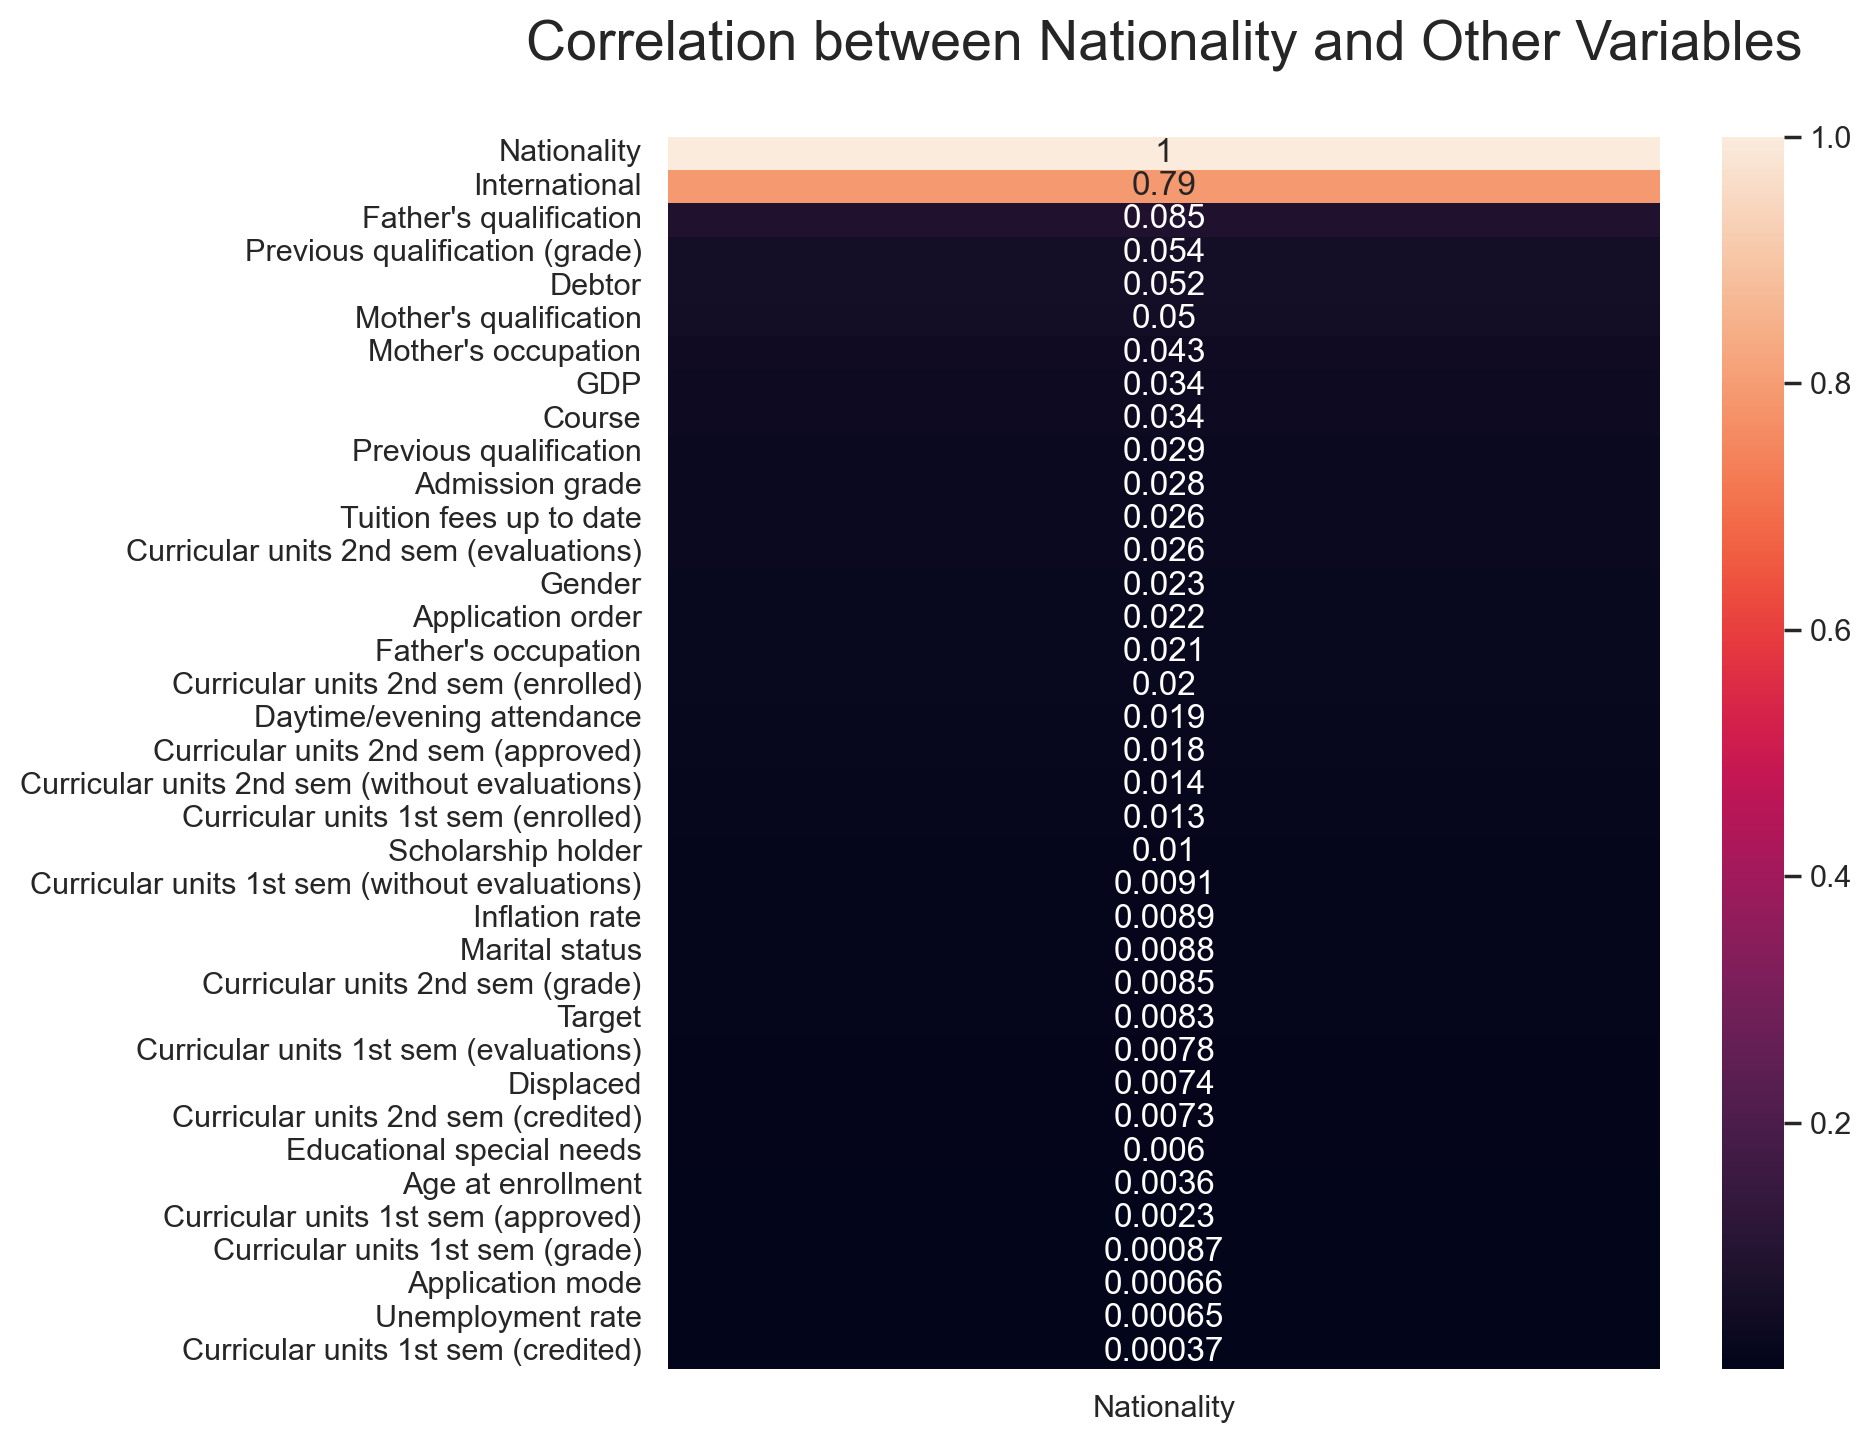

In [188]:
cmap = sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(8, 8), dpi=200)
sns.heatmap(df.corr()[['Nationality']].abs().sort_values(by='Nationality',ascending=False), cmap=cmap, annot=True);
ax.set_title("Correlation between Nationality and Other Variables\n", fontsize=20);

# From the results, we remove Nationality and International
df = df.drop(['Nationality', 'International'], axis=1)

The correlation table shows that Nationality has a positive correlation with the International feature. However, Nationality has a weak correlation with the other features in the dataset, including the Target label we are trying to predict. As a result, removing Nationality and International as features from the classification algorithm will likely not have a substantial impact on the prediction accuracy.

To determine which of the other features are the most helpful, it is important to determine which features appear to be the most correlated with the target variable. In Lab One, we determined this with a correlation table, which orders the features from those with the strongest correlation (in magnitude) to those with the weakest correlation. A feature with a positive correlation is correlated with a lower chance to drop out; a feature with a negative correlation is correlated with a high chance to drop out.

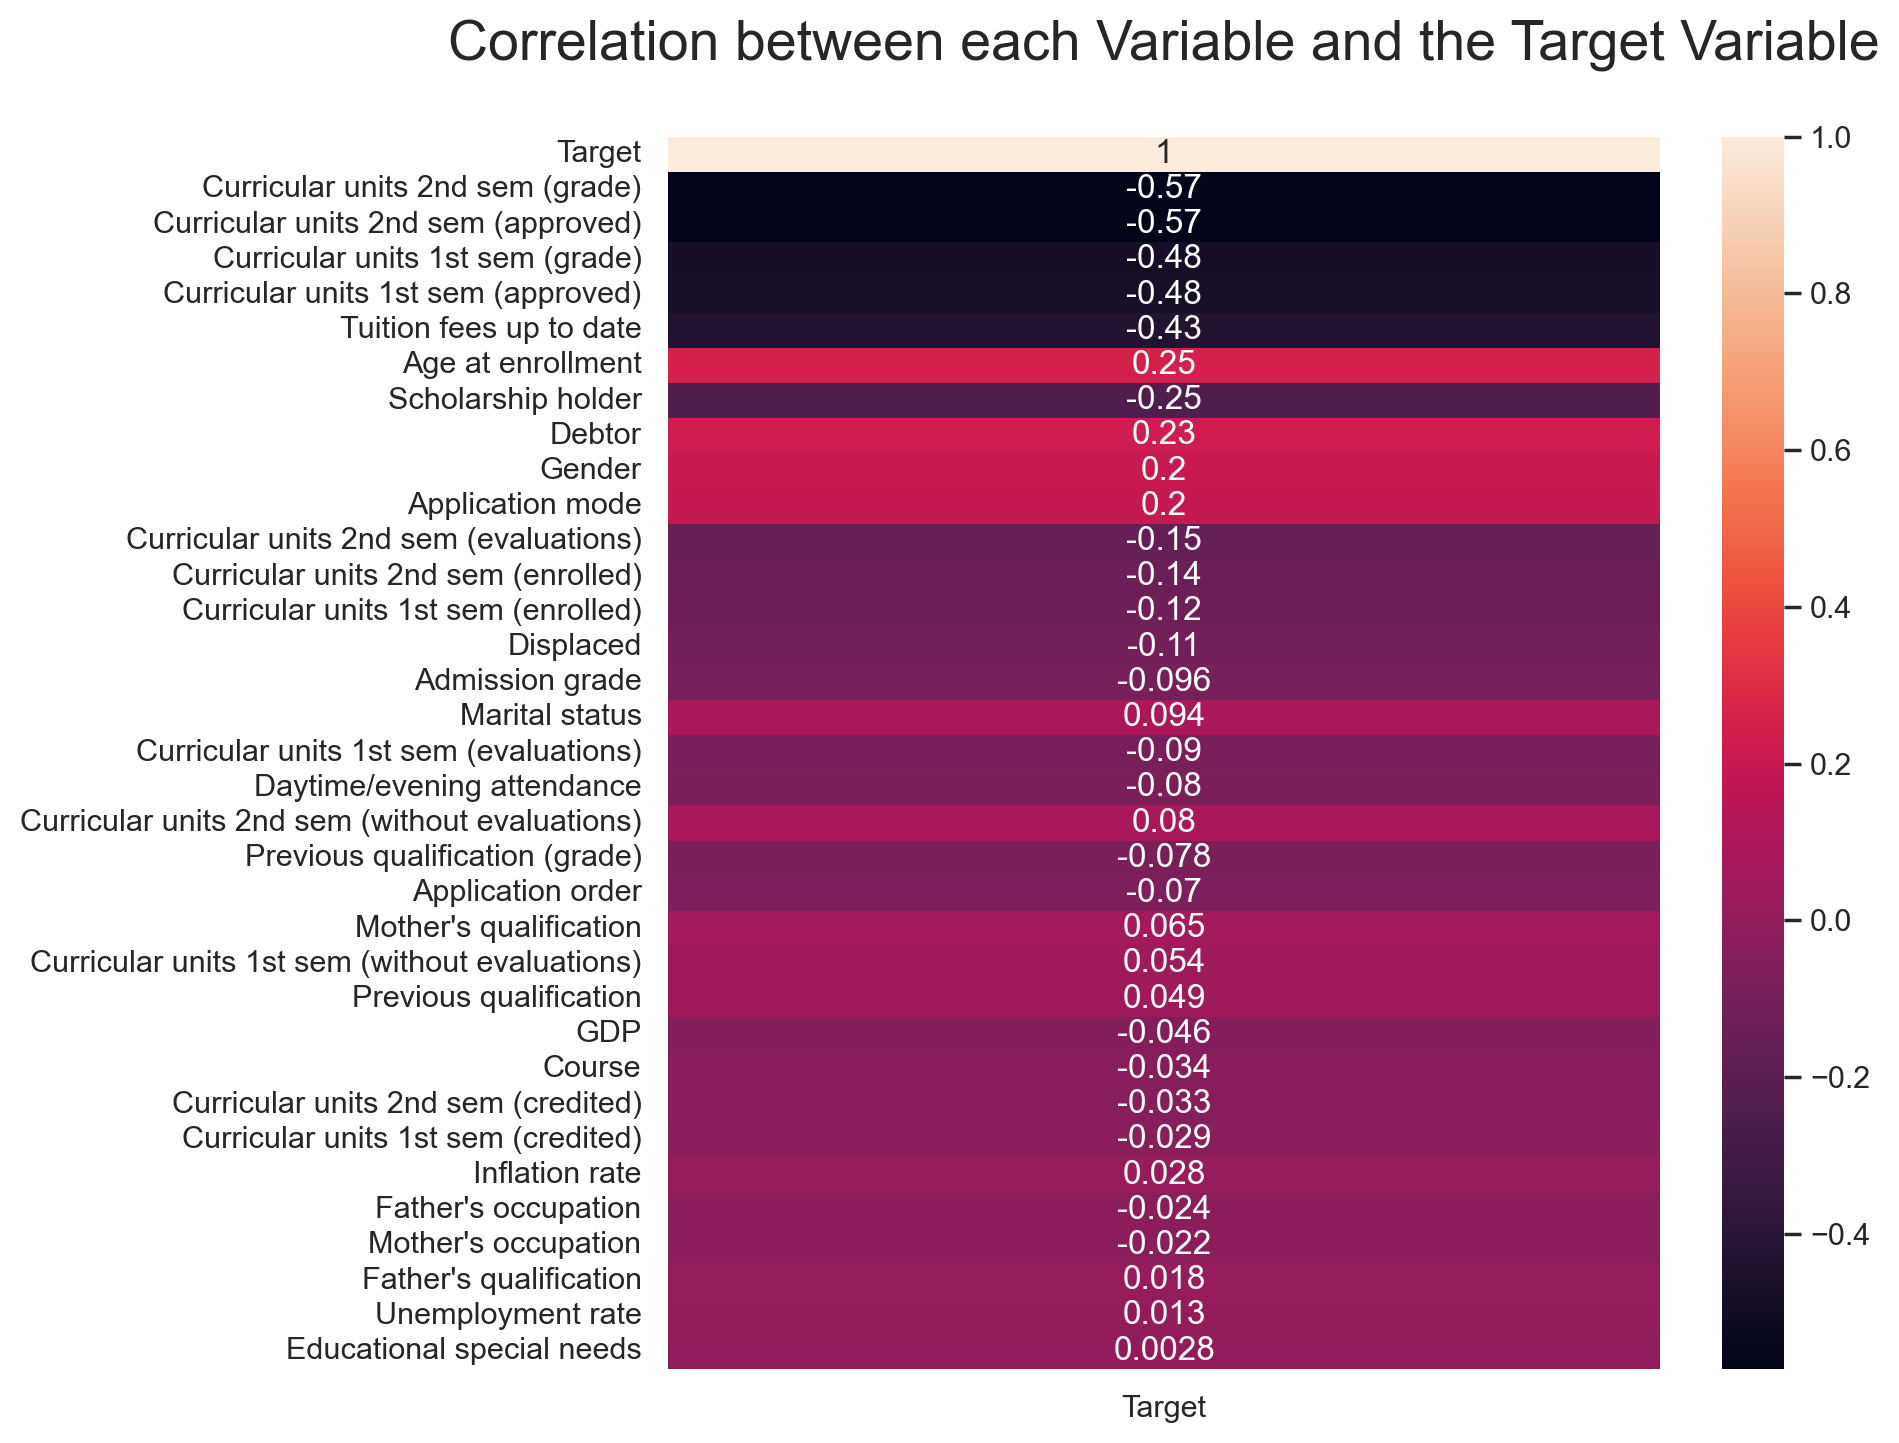

In [190]:
df_target = df.corr()[['Target']]
df_target['abs(Target)'] = df_target['Target'].abs()

cmap = sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(8, 8), dpi=200)
corrs = pd.DataFrame(df_target.sort_values(by='abs(Target)', ascending=False)['Target'])

# Sort the Correlation Coefficients by its Magnitude but output the raw Correlation Coefficient.
sns.heatmap(corrs, cmap=cmap, annot=True);
ax.set_title("Correlation between each Variable and the Target Variable\n", fontsize=20);


The correlation table indicates that several features are unlikely to help us predict whether or not a student will drop out. In our analysis, we decided to remove all features with a correlation magnitude below 0.1 because keeping them may reduce the model's accuracy by including irrelevant information. This leaves us with 15 features.


In [191]:
df = df[corrs[abs(corrs['Target']) >= 0.1].transpose().columns]

In [192]:
df.rename(columns={
    "Tuition fees up to date": "Tuition_fees_up_to_date",
    "Scholarship holder": "Scholarship_holder",
    "Debtor": "Debtor",
    "Gender": "Gender",
    "Application mode": "Application_mode",
    "Displaced": "Displaced",
    "Curricular units 2nd sem (grade)": "Curricular_units_2nd_sem_(grade)",
    "Curricular units 2nd sem (approved)": "Curricular_units_2nd_sem_(approved)",
    "Curricular units 1st sem (grade)": "Curricular_units_1st_sem_(grade)",
    "Curricular units 1st sem (approved)": "Curricular_units_1st_sem_(approved)",
    "Age at enrollment": "Age_at_enrollment",
    "Curricular units 2nd sem (evaluations)": "Curricular_units_2nd_sem_(evaluations)",
    "Curricular units 2nd sem (enrolled)": "Curricular_units_2nd_sem_(enrolled)",
    "Curricular units 1st sem (enrolled)": "Curricular_units_1st_sem_(enrolled)"
}, inplace=True)


## 1.2: Train-Test Split
To divide our data, we will use a shuffled, stratified train-test split of 75-25. Given that our dataset is relatively small with only 4,424 examples, we will use three different shuffled splits to assess our model's performance to ensure that the performance we record is not an outlier based on a specific split. Moreover, a stratified split is necessary because the target class, "Dropouts," represents only 32% of this imbalanced dataset. While this percentage is not extremely low (e.g., less than or equal to 10%), we want to ensure that both the training and test sets have enough instances of Dropouts to accurately reflect the overall distribution. We decided against splitting the test set into a test + validation set because we are not finetuning many parameters in our model training process and this would take away from the amount of data we could use to train and test our model.

In [193]:
stats = pd.DataFrame(counts, columns=counts[0]).iloc[1:]
stats.loc[-1] = counts[1] * 100 / np.sum(counts[1])
stats.reset_index(drop=True)

Dropout Non-Dropout
0       1421        3003
1  32.120253   67.879747

In practice, third parties like university admissions offices and government agencies would predict whether or not incoming university students are likely to dropout or graduate. Universities have a variety of different sizes for their incoming class, ranging from 1,000 students to 8,000 students. To mirror how the algorithm will be used, we decided on a 75% training set (3318 examples) and 25% test set (1106 examples), so we could test how accurate the algorithm would be when predicting on a thousand students.

Sources: [Sizes of Freshman Classes](https://www.forbes.com/sites/michaeltnietzel/2022/08/21/these-colleges-and-universities-are-reporting-record-size-freshmen-classes/)

In [306]:
def split(df, state):
    df_train, df_test = train_test_split(df, test_size=0.25, random_state=state, stratify=df['Target'])
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True);

    return df_train, df_test

In [365]:
df_train, df_test = split(df, state=69)
df_train2, df_test2 = split(df, state=2048)
df_train3, df_test3 = split(df, state=2496)


## 1.3: Cross Features and Scaling

In [366]:
categorical_headers = ["Tuition_fees_up_to_date", "Scholarship_holder", "Debtor", "Gender", "Application_mode", "Displaced"]
numeric_headers = ["Curricular_units_2nd_sem_(grade)", "Curricular_units_2nd_sem_(approved)", "Curricular_units_1st_sem_(grade)", "Curricular_units_1st_sem_(approved)", "Age_at_enrollment", "Curricular_units_2nd_sem_(evaluations)", "Curricular_units_2nd_sem_(enrolled)", "Curricular_units_1st_sem_(enrolled)"]

def create_dataset_from_dataframe(df_input):

    df = df_input.copy()
    labels = df['Target']

    df = {key: value.values[:,np.newaxis] for key, value in df_input[categorical_headers+numeric_headers].items()}

    # create the Dataset here
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    
    # now enable batching and prefetching
    batch_size = 64
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    
    return ds

def preprocess_train_test_data(df_train, df_test, feature_space):
    ds_train = create_dataset_from_dataframe(df_train)
    ds_test = create_dataset_from_dataframe(df_test)
    
    train_ds_with_no_labels = ds_train.map(lambda x, _: x)
    feature_space.adapt(train_ds_with_no_labels)
    
    # # now define a preprocessing operation that returns the processed features
    # preprocessed_ds_train = ds_train.map(lambda x, y: (feature_space(x), y), 
    #                                      num_parallel_calls=tf.data.AUTOTUNE)
    # # run it so that we can use the pre-processed data
    # preprocessed_ds_train = preprocessed_ds_train.prefetch(tf.data.AUTOTUNE)
    
    # # do the same for the test set
    # preprocessed_ds_test = ds_test.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    # preprocessed_ds_test = preprocessed_ds_test.prefetch(tf.data.AUTOTUNE)

    return ds_train, ds_test


Our feature space will one-hot encode all categorical variables, which have already been converted to integers, and scales all the numeric variables. We crossed the following features.
1. Tuition fees up to date x Scholarship holder x Debtor: We wanted to capture several potential factors related to financial hardship when going to university, such as not having a scholarship or previously being in debt.
2. Displaced x Gender: We wanted to capture patterns in how male and female sudents respond to being displaced. Certain genders may have different support systems or life challenges that make it easier or harder for them to adjust to new living situations.
3. Application Mode x Scholarship Holder: Crossing these features could uncover patterns related to students' academic proactivity and engagement. For example, early applicants may secure scholarships based on their academic achievements and early commitment to their studies. In contrast, students who apply later may be more likely to receive scholarships based on financial need.
4. Displaced x Tuition Fees up to Date: Crossing these features could reveal how changes in a student's living situation may heighten financial stress or introduce new logistical challenges associated with relocating. The combined pressures of financial strain and the upheaval of moving could exacerbate stress, potentially influencing the student's likelihood of staying in school and affecting overall retention.

In [367]:
feature_space = FeatureSpace(
    features={
        # Categorical features encoded as integers
        "Tuition_fees_up_to_date": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Scholarship_holder": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Debtor": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Gender": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Application_mode": FeatureSpace.integer_categorical(num_oov_indices=1),
        "Displaced": FeatureSpace.integer_categorical(num_oov_indices=1),

        # Numeric variables
        "Curricular_units_2nd_sem_(grade)": FeatureSpace.float_normalized(),
        "Curricular_units_2nd_sem_(approved)": FeatureSpace.float_normalized(),
        "Curricular_units_1st_sem_(grade)": FeatureSpace.float_normalized(),
        "Curricular_units_1st_sem_(approved)": FeatureSpace.float_normalized(),
        "Age_at_enrollment": FeatureSpace.float_normalized(),
        "Curricular_units_2nd_sem_(evaluations)": FeatureSpace.float_normalized(),
        "Curricular_units_2nd_sem_(enrolled)": FeatureSpace.float_normalized(),
        "Curricular_units_1st_sem_(enrolled)": FeatureSpace.float_normalized(),
    },
    crosses=[
        FeatureSpace.cross(feature_names=('Tuition_fees_up_to_date', 'Scholarship_holder', 'Debtor'), crossing_dim=2*2*2),
        FeatureSpace.cross(feature_names=('Displaced', 'Gender'), crossing_dim=2*2),
        FeatureSpace.cross(feature_names=('Displaced', 'Tuition_fees_up_to_date'), crossing_dim=2*2),
        FeatureSpace.cross(feature_names=('Application_mode', 'Scholarship_holder'), crossing_dim=18*2),
    ],
    output_mode="concat"
)


This is where we preprocess all 3 of our shuffle splits.

In [368]:
ds_train, ds_test = preprocess_train_test_data(df_train, df_test, feature_space)

In [369]:
ds_train2, ds_test2 = preprocess_train_test_data(df_train2, df_test2, feature_space)

In [370]:
ds_train3, ds_test3 = preprocess_train_test_data(df_train3, df_test3, feature_space)

The final dataset has 94 features with 3318 examples in the training data and 1106 examples in the test data. Scaling has been applied for numeric features, and one-hot encoding has been applied for categorical features. Dimensionality reduction (i.e. PCA) has not been applied, but we will apply an embedding layer to the categorical variables to reduce the dimensionality in the model itself.

In [319]:
preprocessed_ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 94), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## 1.4: Evaluation Metrics

We decided to use metrics like precision and recall to measure our algorithm's success because the algorithm only needs to succeed at identifying which students are at high risk of dropping out. It is less important if the model inaccurately predicts an Enrollee as a Graduate or vice versa. For our algorithm, recall measures the percentage of actual dropouts that the algorithm correctly classifies. Our recall should be as close as possible to 100% to minimize the probability of missing any students at risk of dropping out. Precision measures the percentage of students predicted to drop out who are actual dropouts. Low precision means we are giving additional resources to many students not at risk of dropping out, while high precision means that resources are used effectively. Although high precision is ideal, it would be acceptable to have lower precision, like 70%, if it significantly increases recall.  The balance between precision and recall will depend on how much financial flexibility institutions have.

# 2. Modeling

In [293]:
Metrics = [
    Precision(name='precision'),
    Recall(name='recall'),
    "accuracy"
]

### 2.1: Source Functions

In [354]:
def setup_embedding_from_categorical(feature_space, col_name):
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = len(feature_space.preprocessors[col_name].get_vocabulary())
    
    # get the output from the feature space, which is input to embedding
    x = feature_space.preprocessors[col_name].output
    
    # now use an embedding to deal with integers from feature space
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x # return the tensor here 

def setup_embedding_from_crossing(feature_space, col_name):
    # what the maximum integer value for this variable?
    
    # get the size of the feature
    N = feature_space.crossers[col_name].num_bins
    x = feature_space.crossers[col_name].output
    
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x

def calculate_deep_wide_branch(feature_space, numeric_headers, categorical_headers):
    # we need to create separate lists for each branch
    crossed_outputs = []
    
    # for each crossed variable, make an embedding
    for col in feature_space.crossers.keys():
        
        x = setup_embedding_from_crossing(feature_space, col)
        
        # save these outputs in list to concatenate later
        crossed_outputs.append(x)
        
    
    # now concatenate the outputs and add a fully connected layer
    wide_branch = Concatenate(name='wide_concat')(crossed_outputs)
    
    # reset this input branch
    all_deep_branch_outputs = []
    
    # for each numeric variable, just add it in after embedding
    for idx,col in enumerate(numeric_headers):
        x = feature_space.preprocessors[col].output
        x = tf.cast(x,float) # cast an integer as a float here
        all_deep_branch_outputs.append(x)
        
    # for each categorical variable
    for col in categorical_headers:
        
        # get the output tensor from ebedding layer
        x = setup_embedding_from_categorical(feature_space, col)
        
        # save these outputs in list to concatenate later
        all_deep_branch_outputs.append(x)

    # merge the deep branches together
    deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)

    return wide_branch, deep_branch

def plot_metrics(history):
    plt.figure(figsize=(20,5), dpi=200)
    plt.subplot(1,4,1)
    plt.plot(history.history['precision'])
    plt.xlabel('epochs')
    plt.ylabel('Precision')
    plt.title('Precision over Epochs')
    plt.plot(history.history['val_precision'])
    
    plt.subplot(1,4,2)
    plt.plot(history.history['recall'], label='Training')
    plt.ylabel('Recall')
    plt.xlabel('epochs')
    plt.title('Recall over Epochs')
    plt.plot(history.history['val_recall'], label='Validation')

    plt.subplot(1,4,3)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    
    plt.subplot(1,4,4)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('epochs')

    plt.tight_layout()
    plt.show()

def make_network(units, ds_train, ds_test, feature_space, numeric_headers, categorical_headers, wide_part=True):
    dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output
    wide_branch, deep_branch = calculate_deep_wide_branch(feature_space, numeric_headers, categorical_headers)

    for number in units:
        deep_branch = Dense(units=number,activation='relu')(deep_branch)
        
    # merge the deep and wide branch
    if wide_part:
        final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch]) # Eliminate this to only use the deep branch
    else:
        final_branch = deep_branch
    
    final_branch = Dense(units=1, activation='sigmoid', name='d')(final_branch)
    
    training_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
    training_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=Metrics)

    history = training_model.fit(
        ds_train, epochs=25, validation_data=ds_test, verbose=0
    )
    
    # Print only the last epoch details
    last_epoch = history.history
    print(f"Epoch {len(last_epoch['loss'])}/{len(last_epoch['loss'])}")
    print(f"Validation Loss: {last_epoch['val_loss'][-1]:.4f}")
    print(f"Validation Accuracy: {last_epoch['val_accuracy'][-1]:.4f}")
    print(f"Validation Precision: {last_epoch['val_precision'][-1]:.4f}")
    print(f"Validation Recall: {last_epoch['val_recall'][-1]:.4f}")

    predictions = training_model.predict(ds_test, verbose=0);
    return history, predictions, last_epoch['val_precision'][-1], last_epoch['val_recall'][-1]

### 2.2: Model A
Model A is a deep and wide network with only 2 layers, one with 40 nodes and one with 20 nodes.

Model 1
Epoch 25/25
Validation Loss: 0.3135
Validation Accuracy: 0.8689
Validation Precision: 0.8671
Validation Recall: 0.6986


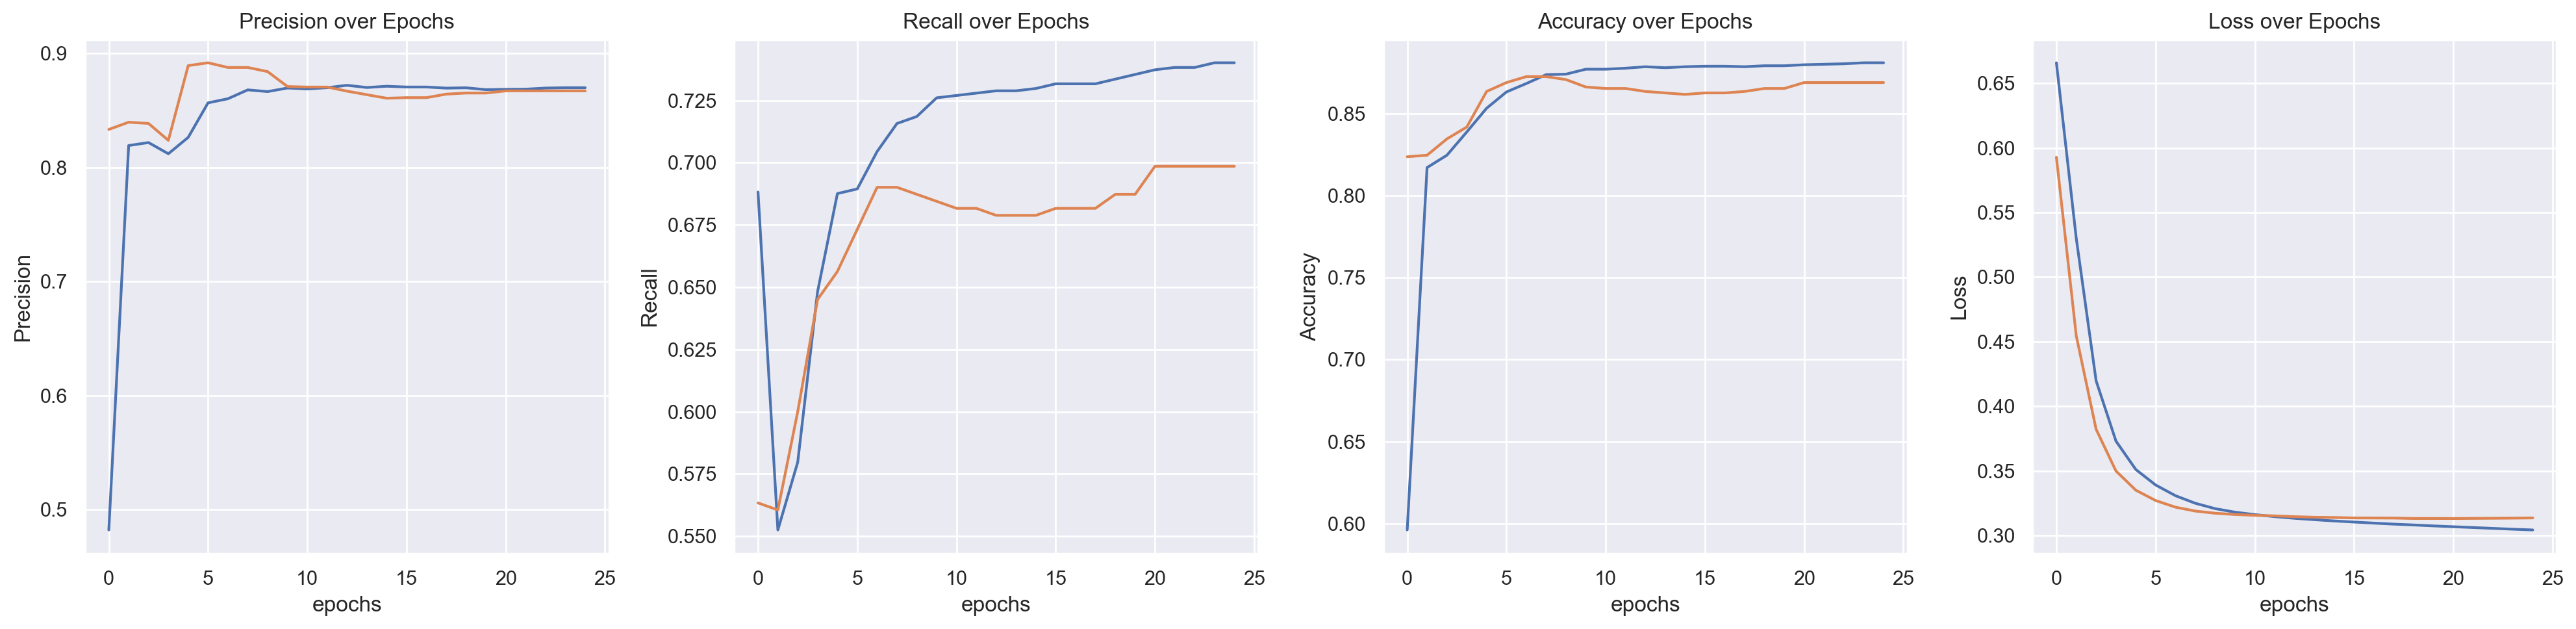

Model 2
Epoch 25/25
Validation Loss: 0.3286
Validation Accuracy: 0.8761
Validation Precision: 0.8516
Validation Recall: 0.7437


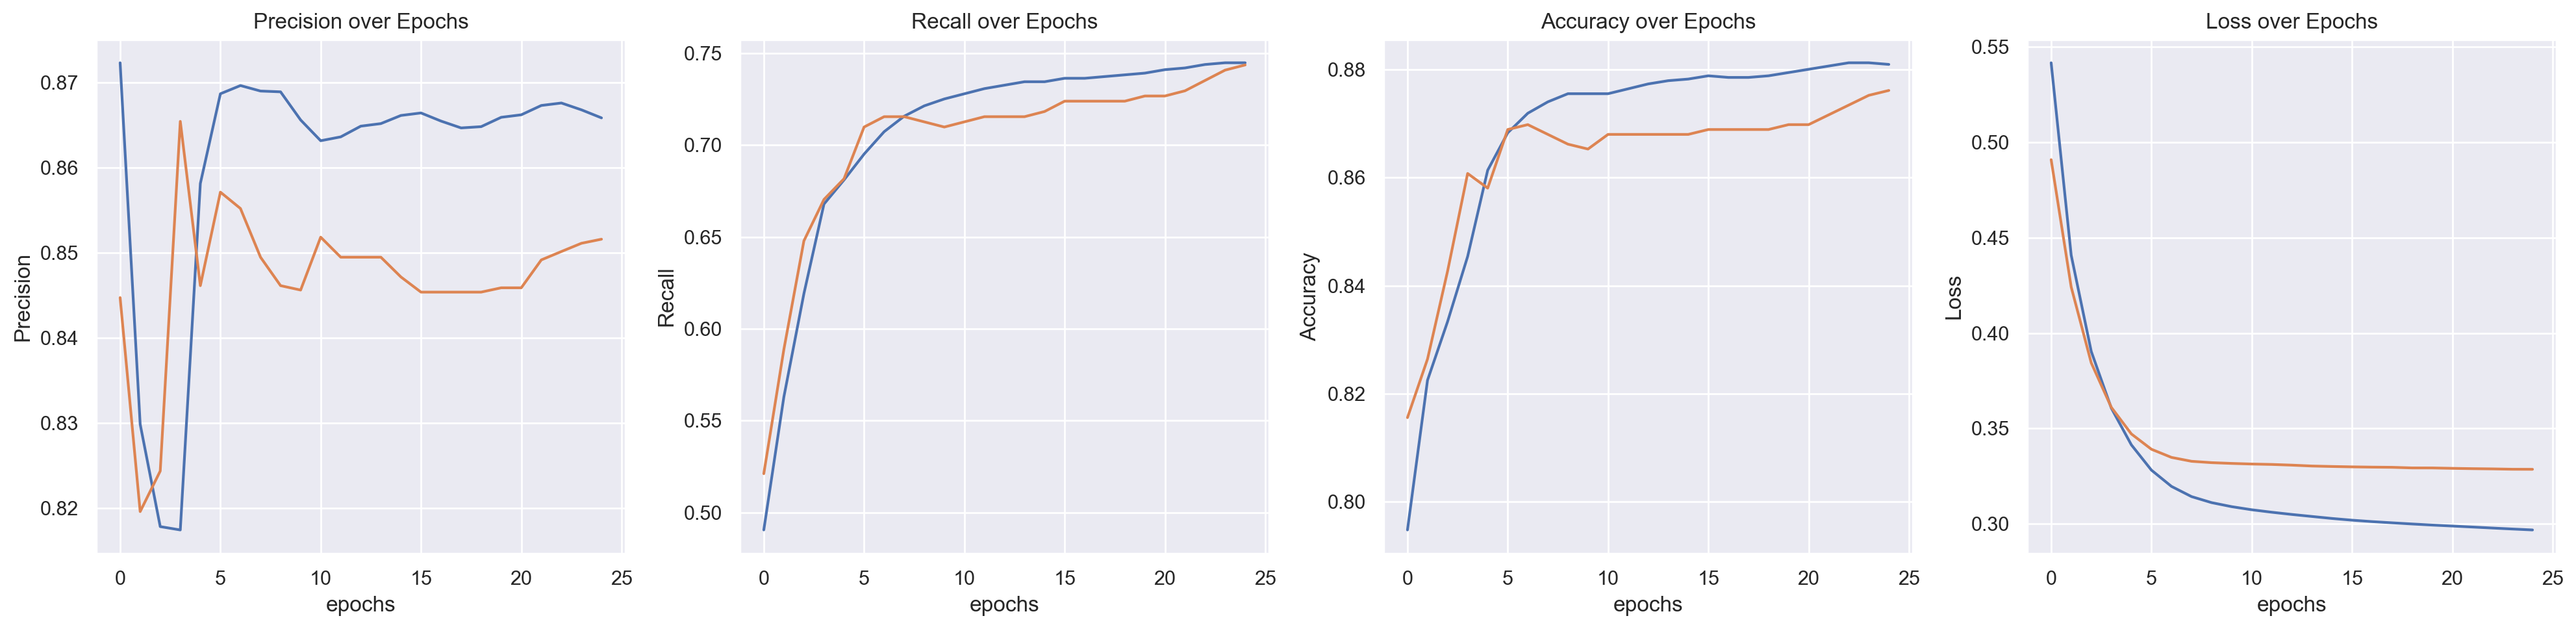

Model 3
Epoch 25/25
Validation Loss: 0.3347
Validation Accuracy: 0.8689
Validation Precision: 0.8477
Validation Recall: 0.7211


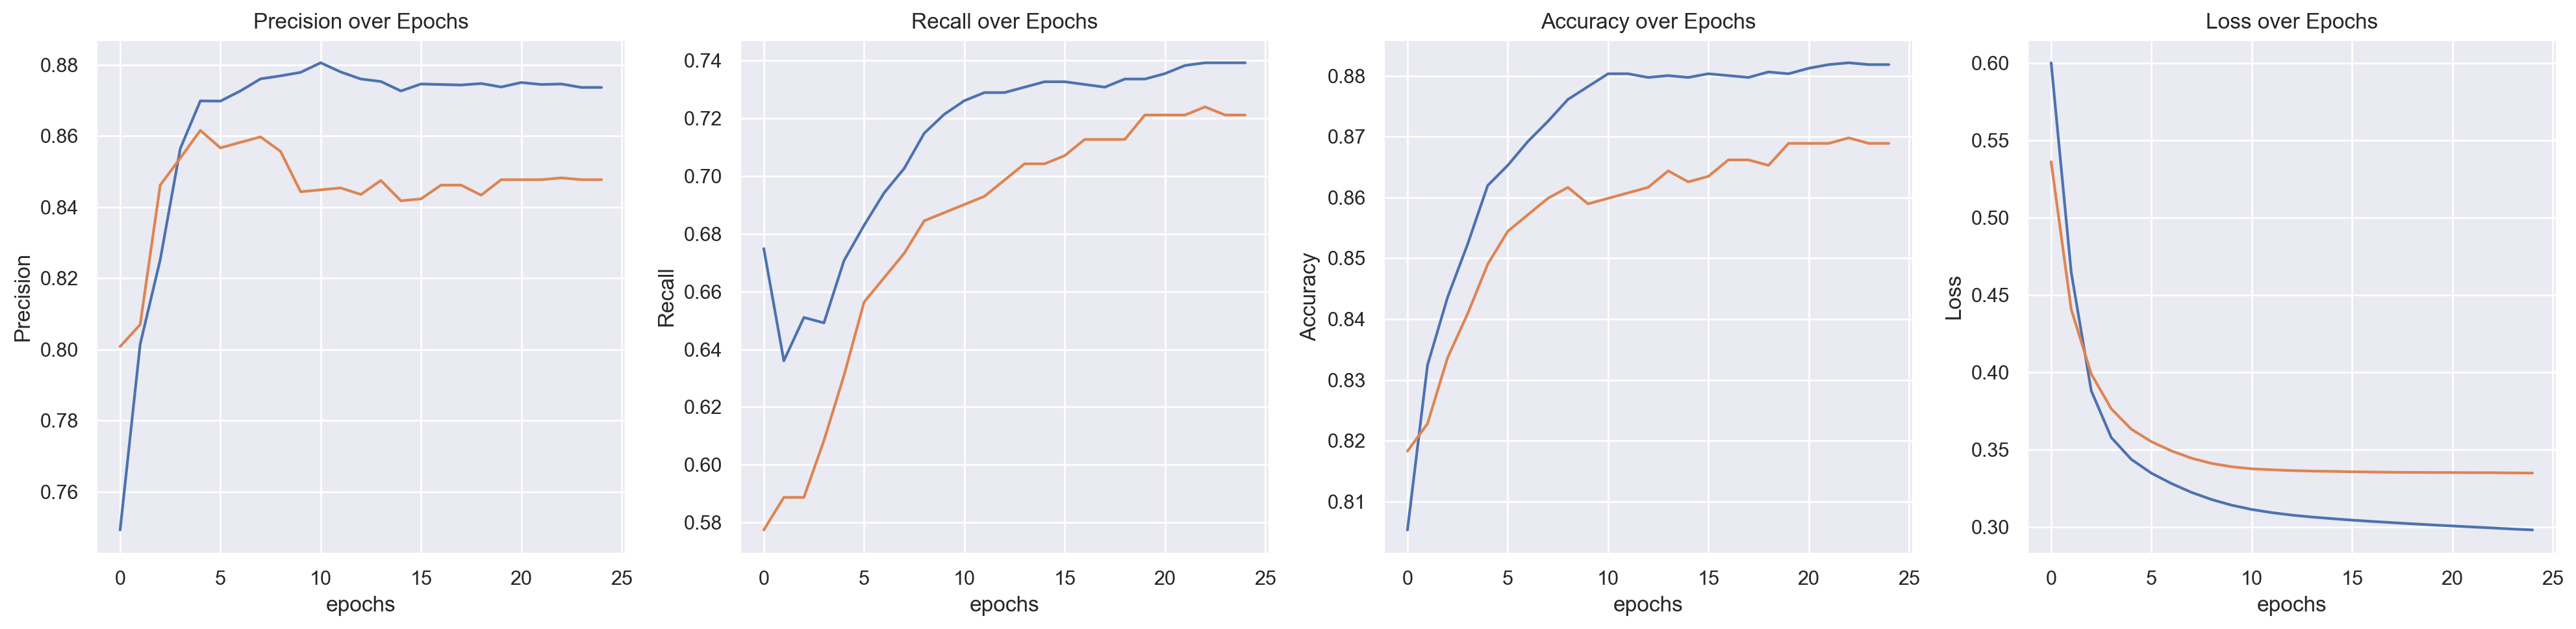

Average Precision: 0.8555
Average Recall: 0.7211


In [375]:
# Units controls the number of nodes in each layer.
units=[20,10]

%matplotlib inline
precision = 0
recall = 0

print("Model 1")
hist1, pred1, prec, reca = make_network(units, ds_train, ds_test, feature_space, 
                            numeric_headers, categorical_headers, wide_part=True)
precision += prec
recall += reca
plot_metrics(hist1)

print("Model 2")
hist2, pred2, prec, reca = make_network(units, ds_train2, ds_test2, feature_space, 
                            numeric_headers, categorical_headers, wide_part=True)
precision += prec
recall += reca
plot_metrics(hist2)

print("Model 3")
hist3, pred3, prec, reca = make_network(units, ds_train3, ds_test3, feature_space, 
                            numeric_headers, categorical_headers, wide_part=True)
precision += prec
recall += reca
plot_metrics(hist3)

print(f"Average Precision: {(precision / 3):.4f}")
print(f"Average Recall: {(recall / 3):.4f}")

### 2.3: Model B
Model B is a deep and wide network with only 3 layers with 40 nodes, 20 nodes, and 10 nodes respectively.

Model 1
Epoch 25/25
Validation Loss: 0.3193
Validation Accuracy: 0.8680
Validation Precision: 0.8449
Validation Recall: 0.7211


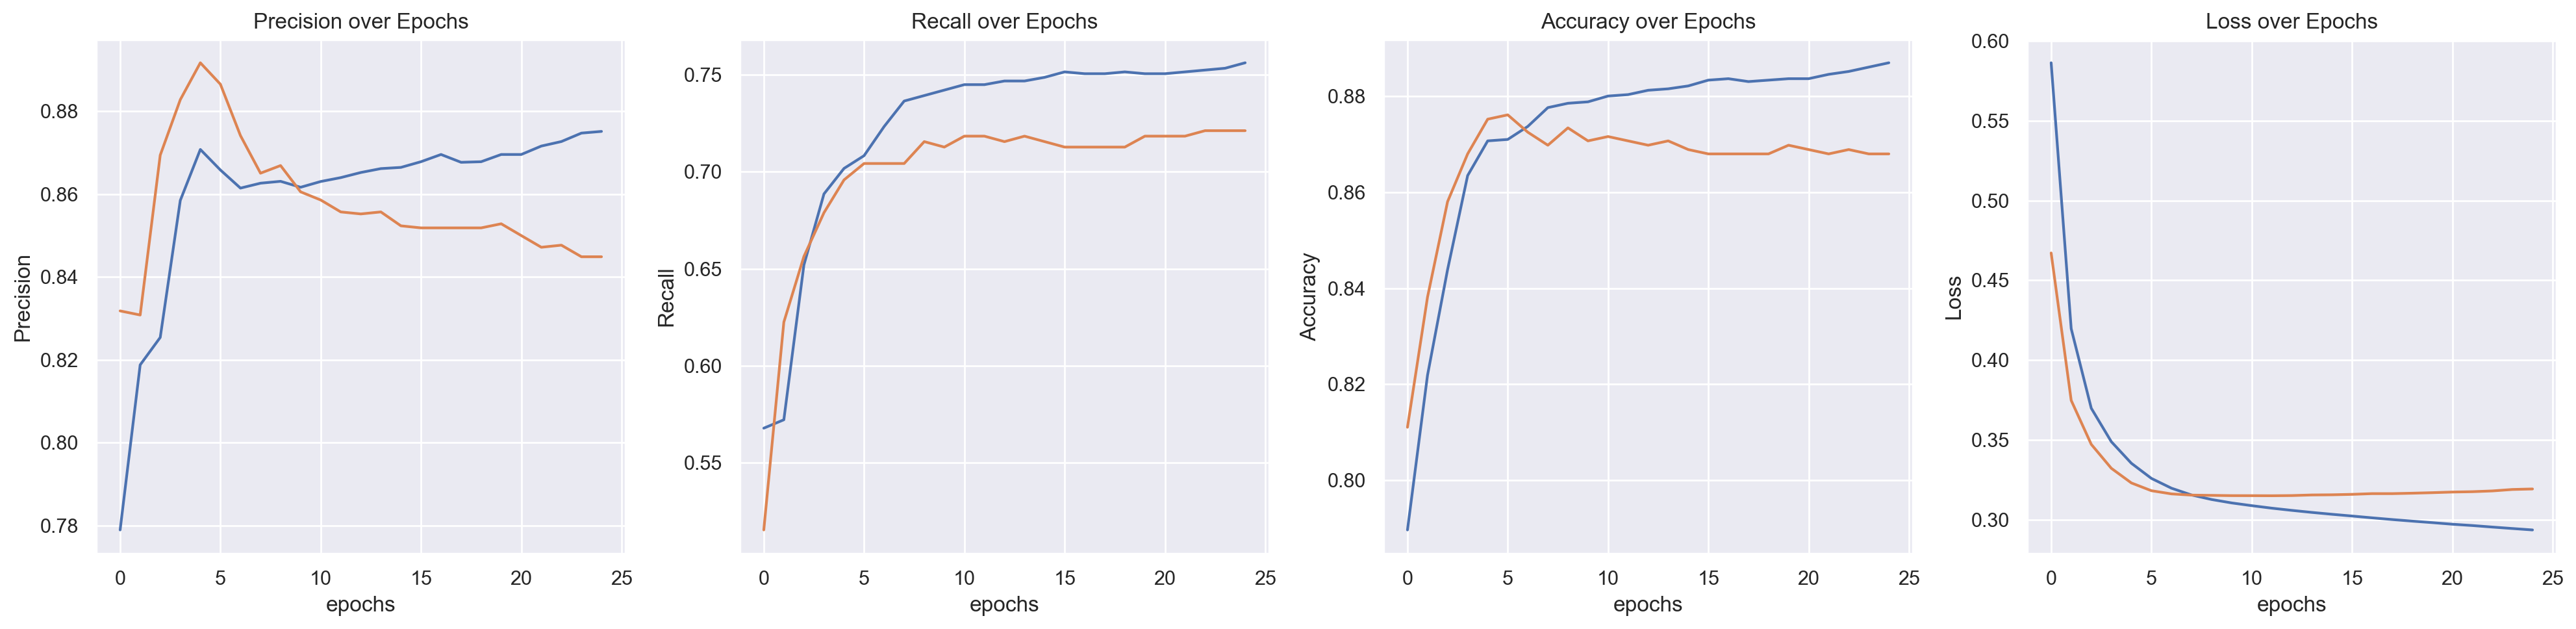

Model 2
Epoch 25/25
Validation Loss: 0.3251
Validation Accuracy: 0.8707
Validation Precision: 0.8510
Validation Recall: 0.7239


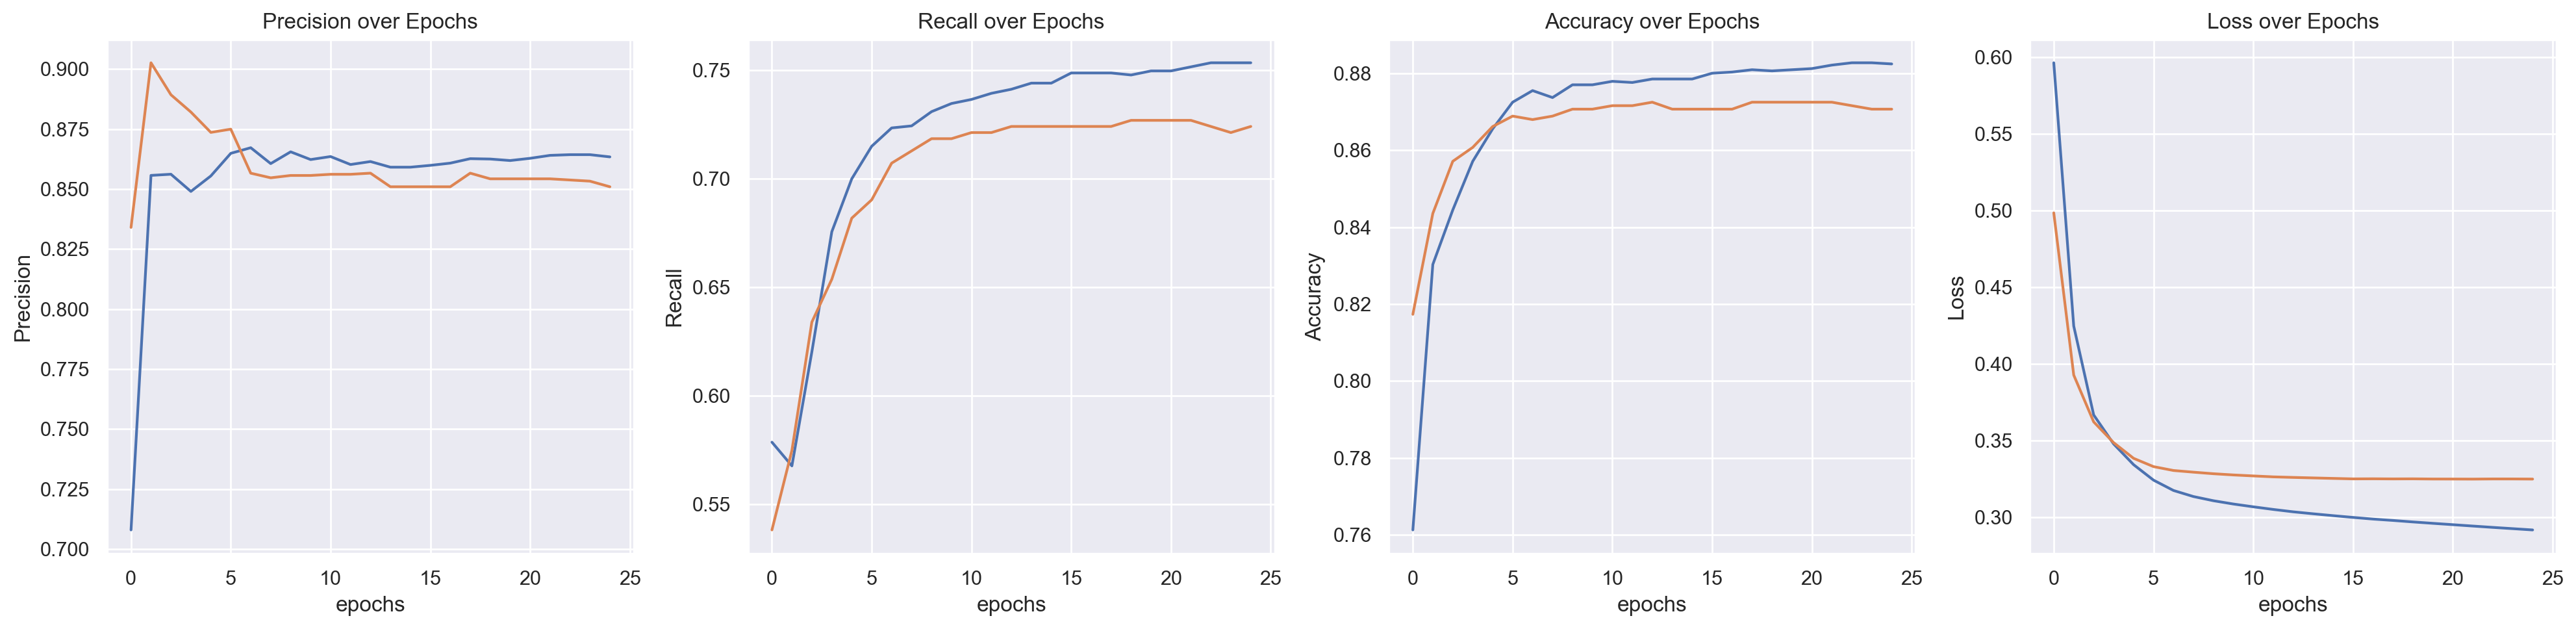

Model 3
Epoch 25/25
Validation Loss: 0.3372
Validation Accuracy: 0.8590
Validation Precision: 0.8328
Validation Recall: 0.7014


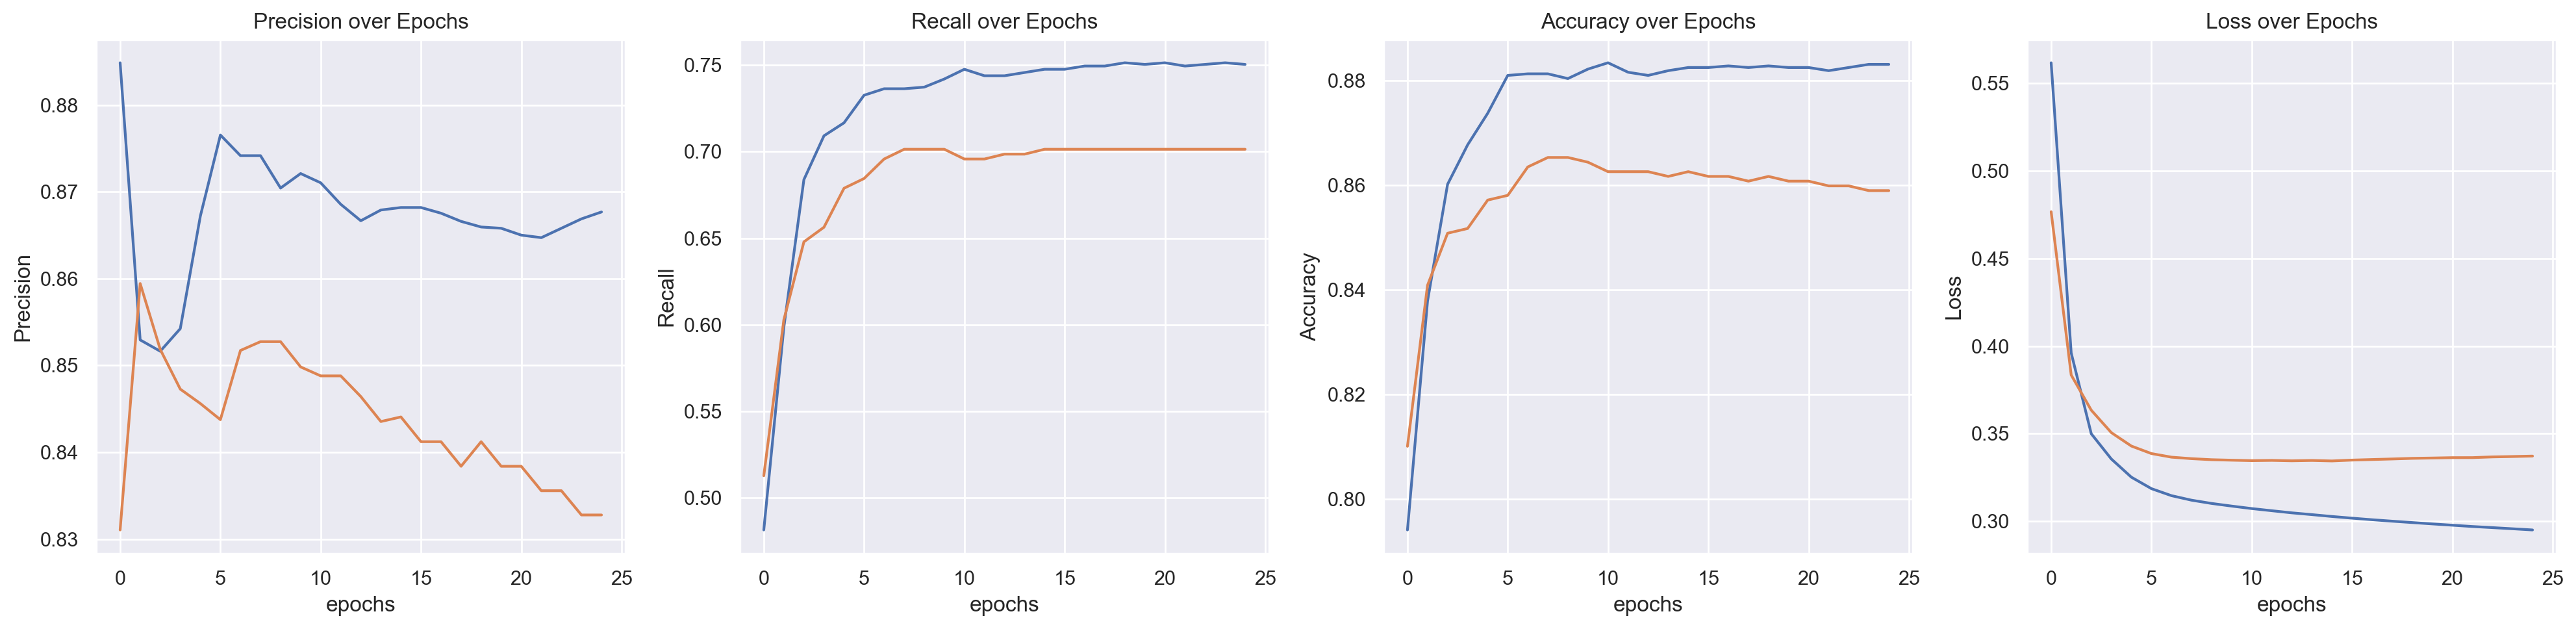

Average Precision: 0.8429
Average Recall: 0.7155


In [376]:
# Units controls the number of nodes in each layer.
units=[40,20,10]

%matplotlib inline
precision = 0
recall = 0

print("Model 1")
hist1, pred1, prec, reca = make_network(units, ds_train, ds_test, feature_space, 
                            numeric_headers, categorical_headers, wide_part=True)
precision += prec
recall += reca
plot_metrics(hist1)

print("Model 2")
hist2, pred2, prec, reca = make_network(units, ds_train2, ds_test2, feature_space, 
                            numeric_headers, categorical_headers, wide_part=True)
precision += prec
recall += reca
plot_metrics(hist2)

print("Model 3")
hist3, pred3, prec, reca = make_network(units, ds_train3, ds_test3, feature_space, 
                            numeric_headers, categorical_headers, wide_part=True)
precision += prec
recall += reca
plot_metrics(hist3)

print(f"Average Precision: {(precision / 3):.4f}")
print(f"Average Recall: {(recall / 3):.4f}")

### 2.4: Model C
Model C is a deep and wide network with only 4 layers with 40 nodes, 20 nodes, 10 nodes, and 10 nodes respectively.

Model 1
Epoch 25/25
Validation Loss: 0.3179
Validation Accuracy: 0.8689
Validation Precision: 0.8454
Validation Recall: 0.7239


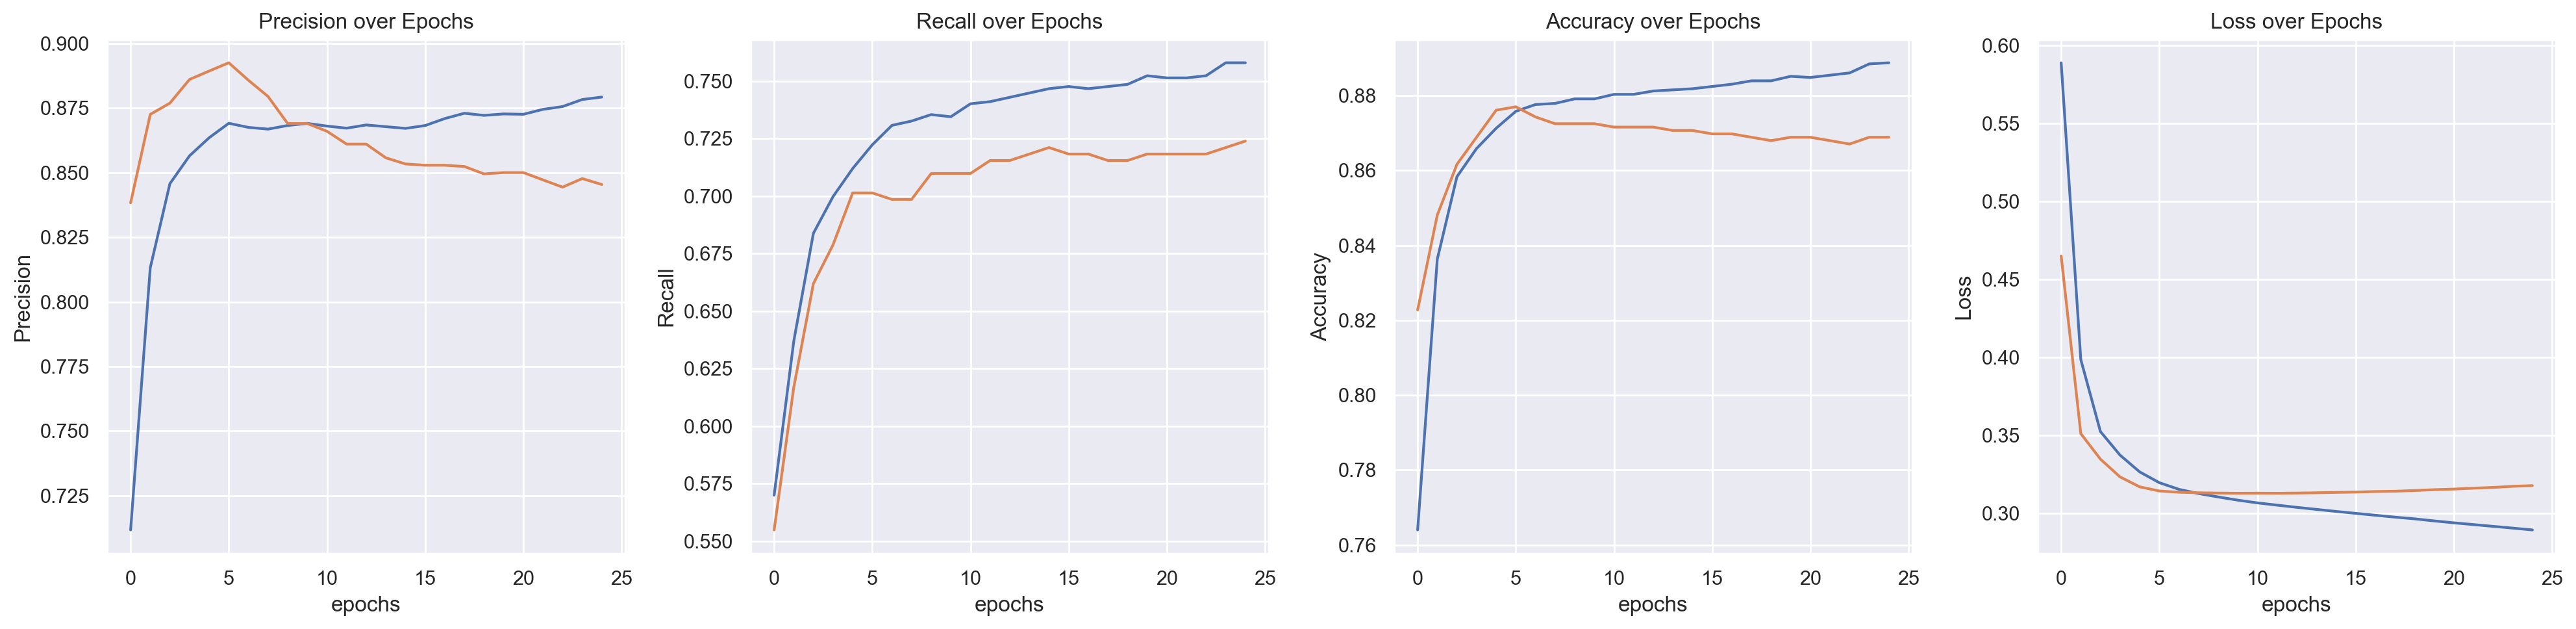

Model 2
Epoch 25/25
Validation Loss: 0.3256
Validation Accuracy: 0.8770
Validation Precision: 0.8638
Validation Recall: 0.7324


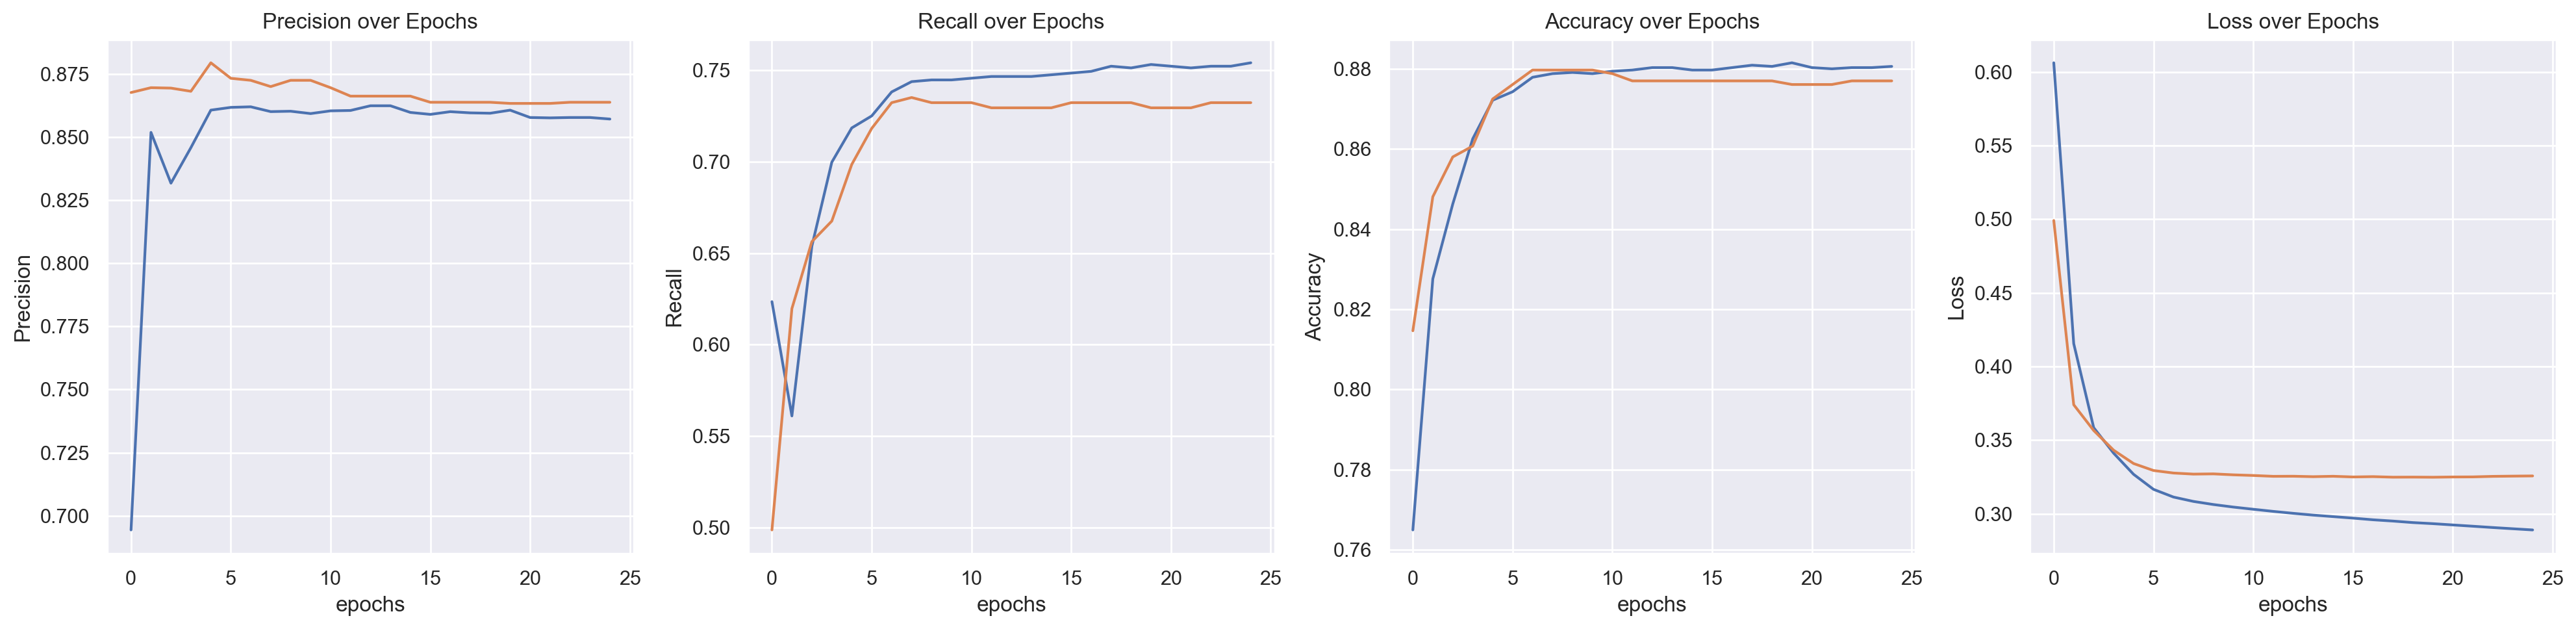

Model 3
Epoch 25/25
Validation Loss: 0.3353
Validation Accuracy: 0.8689
Validation Precision: 0.8431
Validation Recall: 0.7268


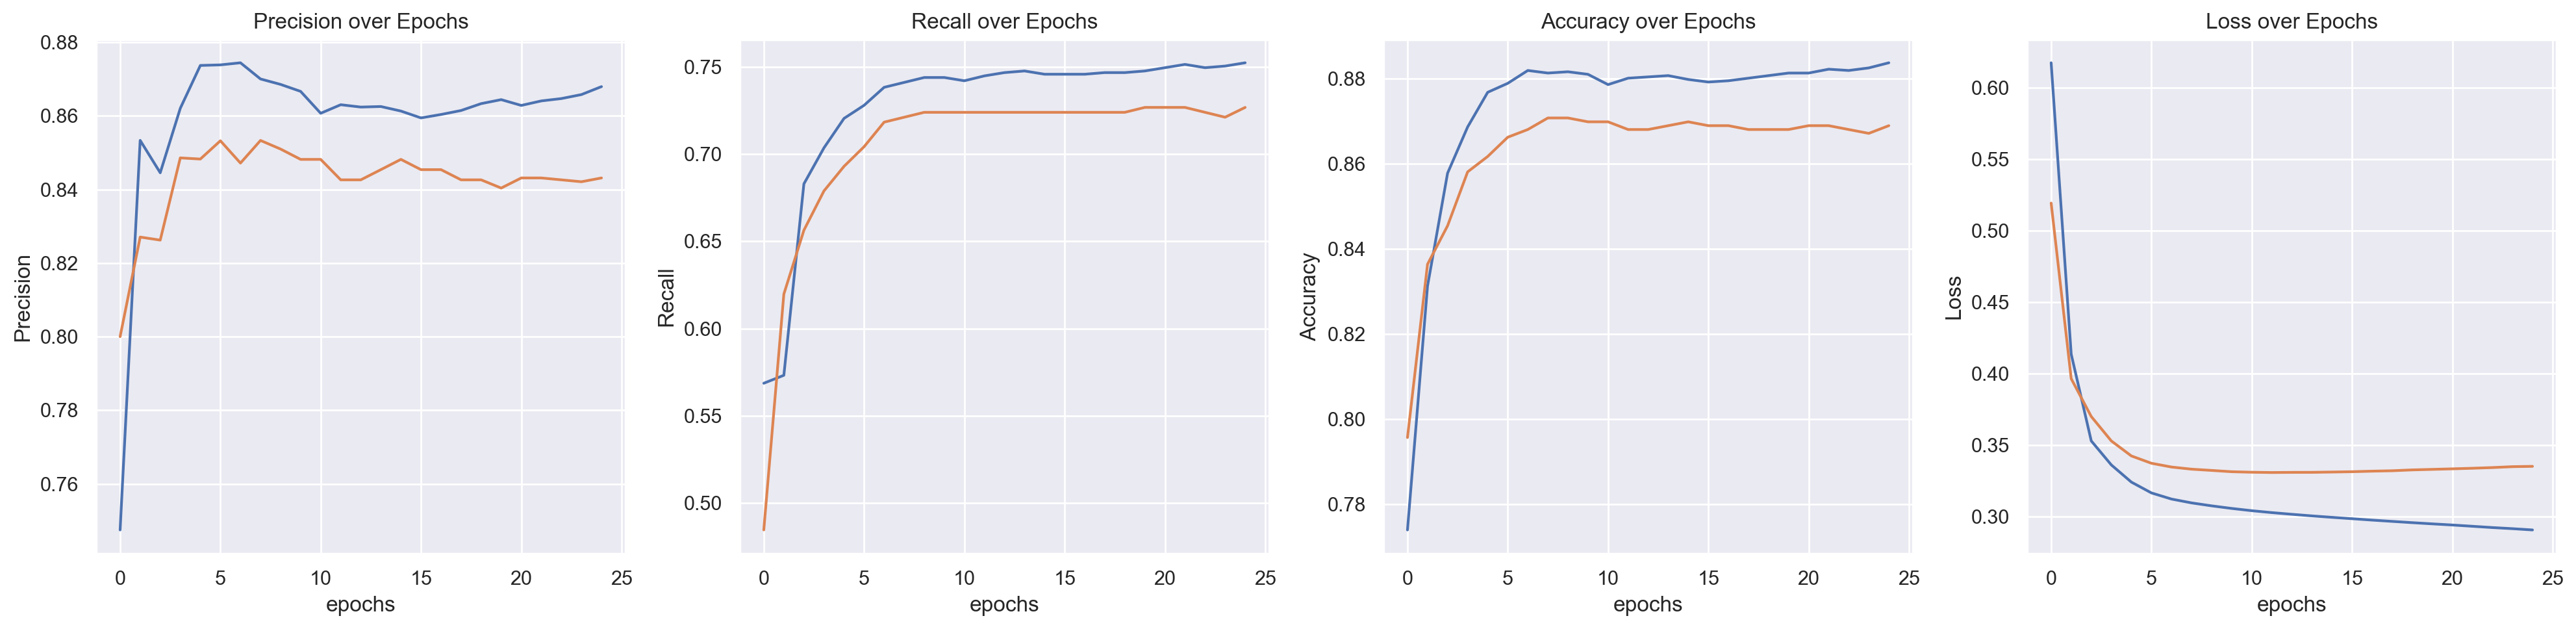

Average Precision: 0.8508
Average Recall: 0.7277


In [377]:
# Units controls the number of nodes in each layer.
units=[40,20,10,10]

%matplotlib inline
precision = 0
recall = 0

print("Model 1")
hist1, pred1, prec, reca = make_network(units, ds_train, ds_test, feature_space, 
                            numeric_headers, categorical_headers, wide_part=True)
precision += prec
recall += reca
plot_metrics(hist1)

print("Model 2")
hist2, pred2, prec, reca = make_network(units, ds_train2, ds_test2, feature_space, 
                            numeric_headers, categorical_headers, wide_part=True)
precision += prec
recall += reca
plot_metrics(hist2)

print("Model 3")
hist3, pred3, prec, reca = make_network(units, ds_train3, ds_test3, feature_space, 
                            numeric_headers, categorical_headers, wide_part=True)
precision += prec
recall += reca
plot_metrics(hist3)

print(f"Average Precision: {(precision / 3):.4f}")
print(f"Average Recall: {(recall / 3):.4f}")

### 2.5: Extra Work: Model D
Model D is a deep and wide network with only 6 layers. This is only model we tried where the number of nodes did not decrease every layer.

Model 1
Epoch 25/25
Validation Loss: 0.3238
Validation Accuracy: 0.8662
Validation Precision: 0.8224
Validation Recall: 0.7437


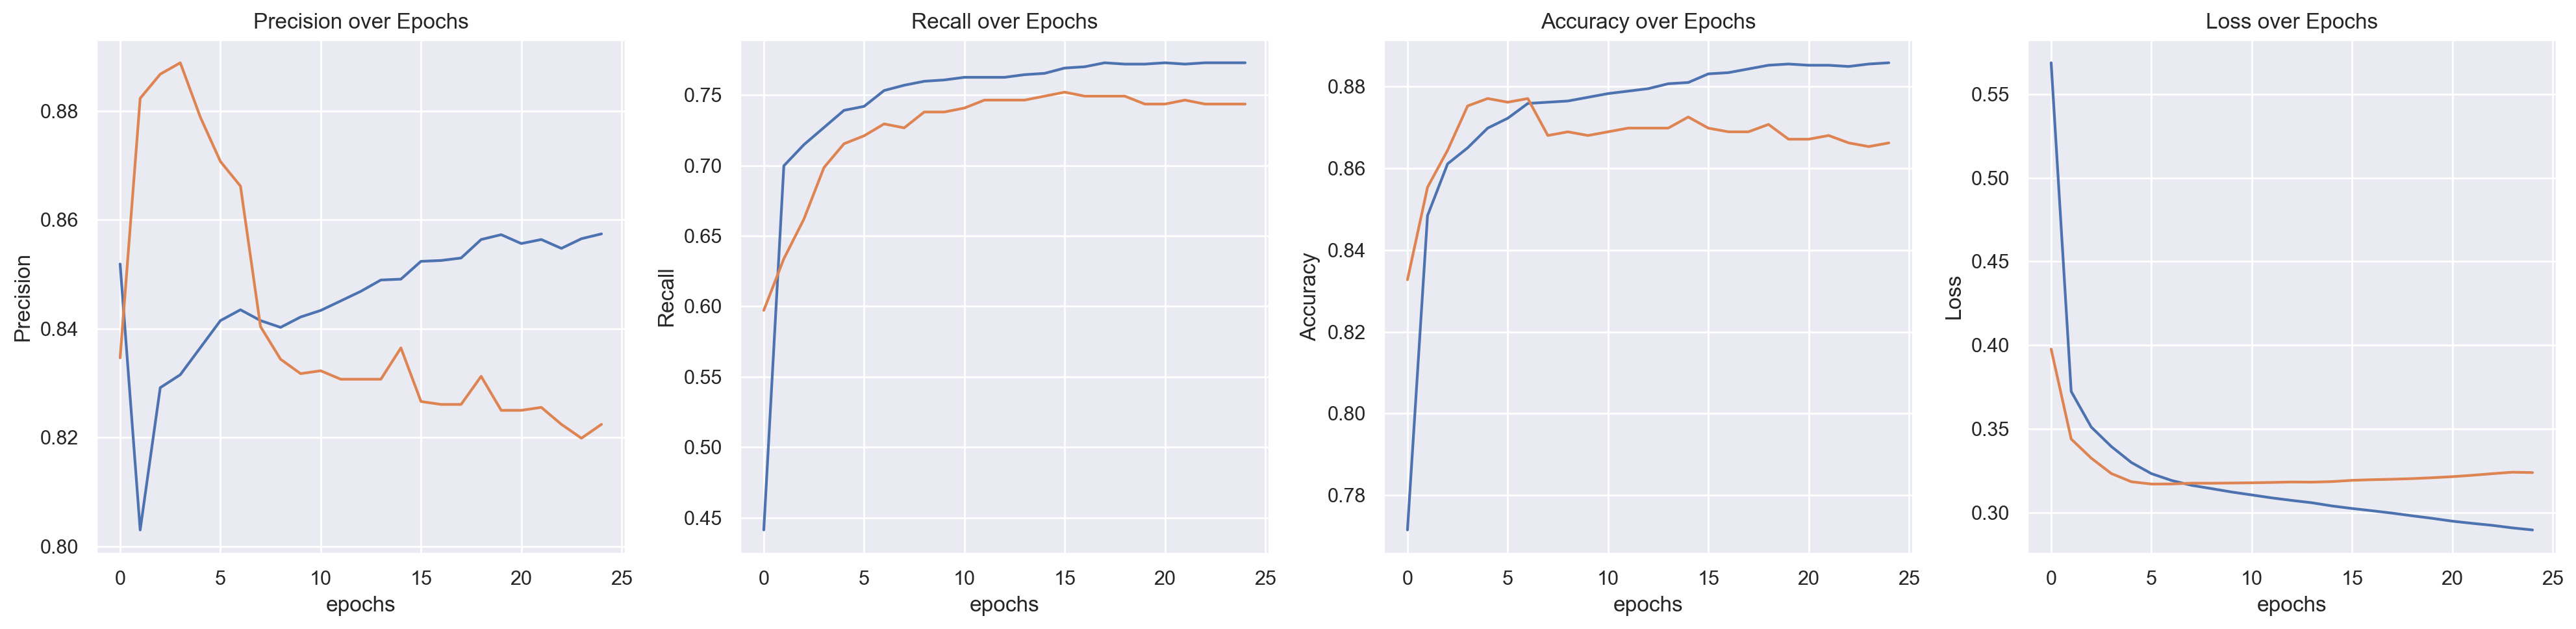

Model 2
Epoch 25/25
Validation Loss: 0.3296
Validation Accuracy: 0.8662
Validation Precision: 0.8245
Validation Recall: 0.7408


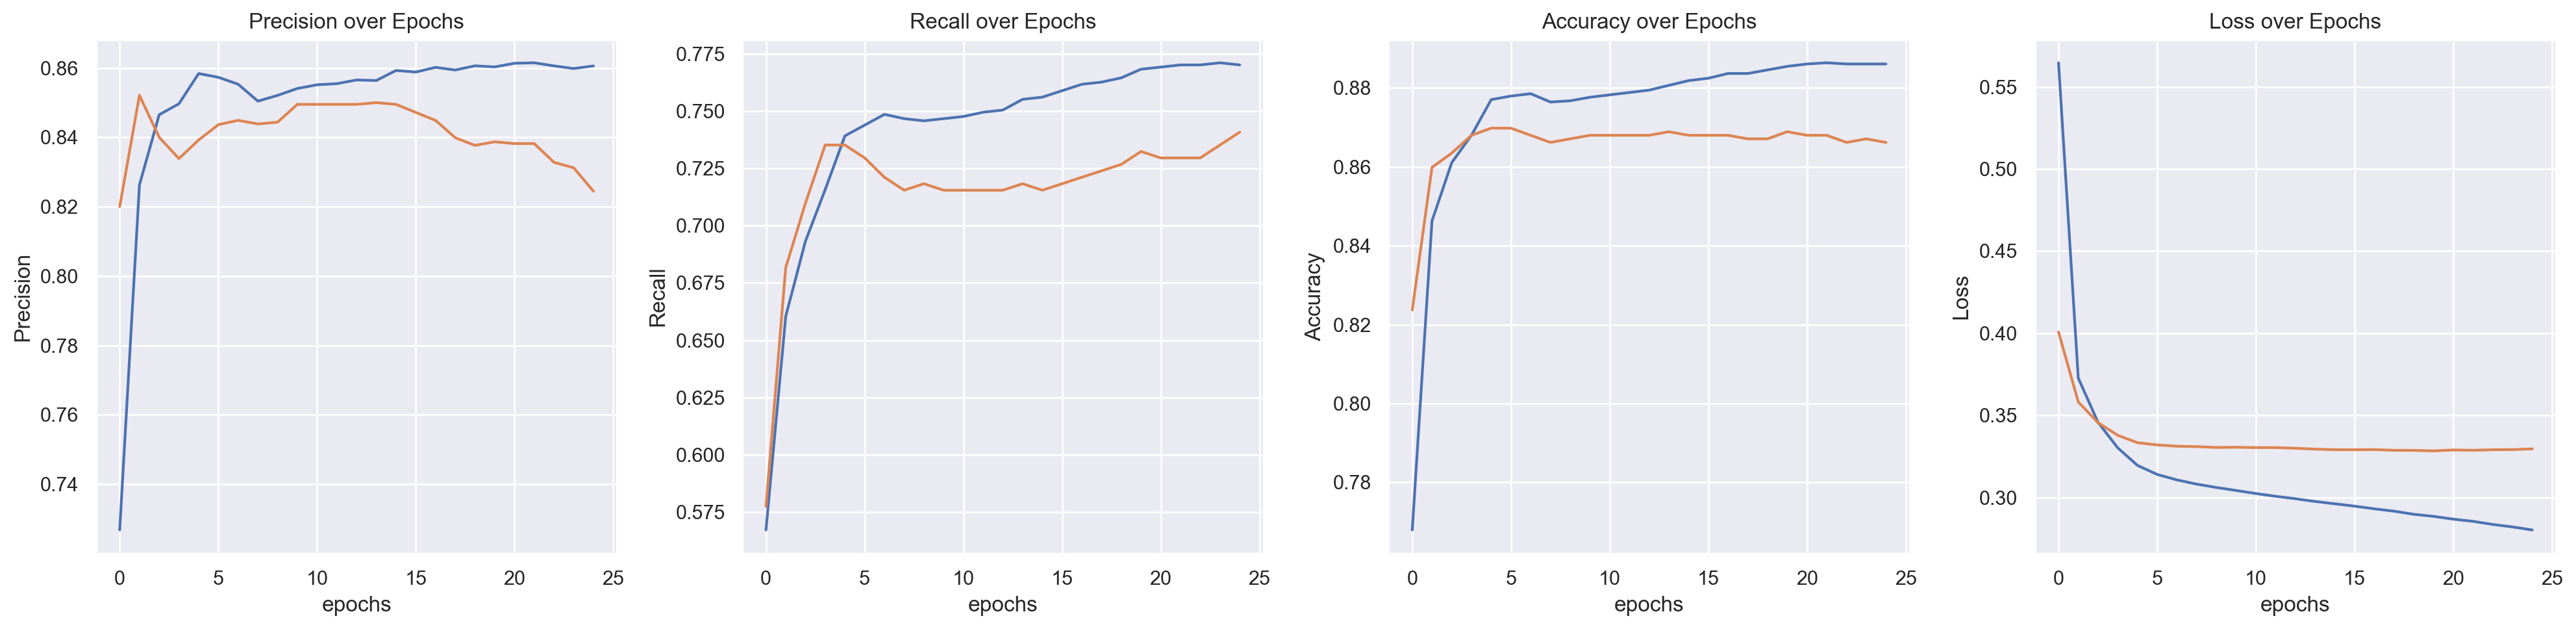

Model 3
Epoch 25/25
Validation Loss: 0.3550
Validation Accuracy: 0.8608
Validation Precision: 0.8131
Validation Recall: 0.7352


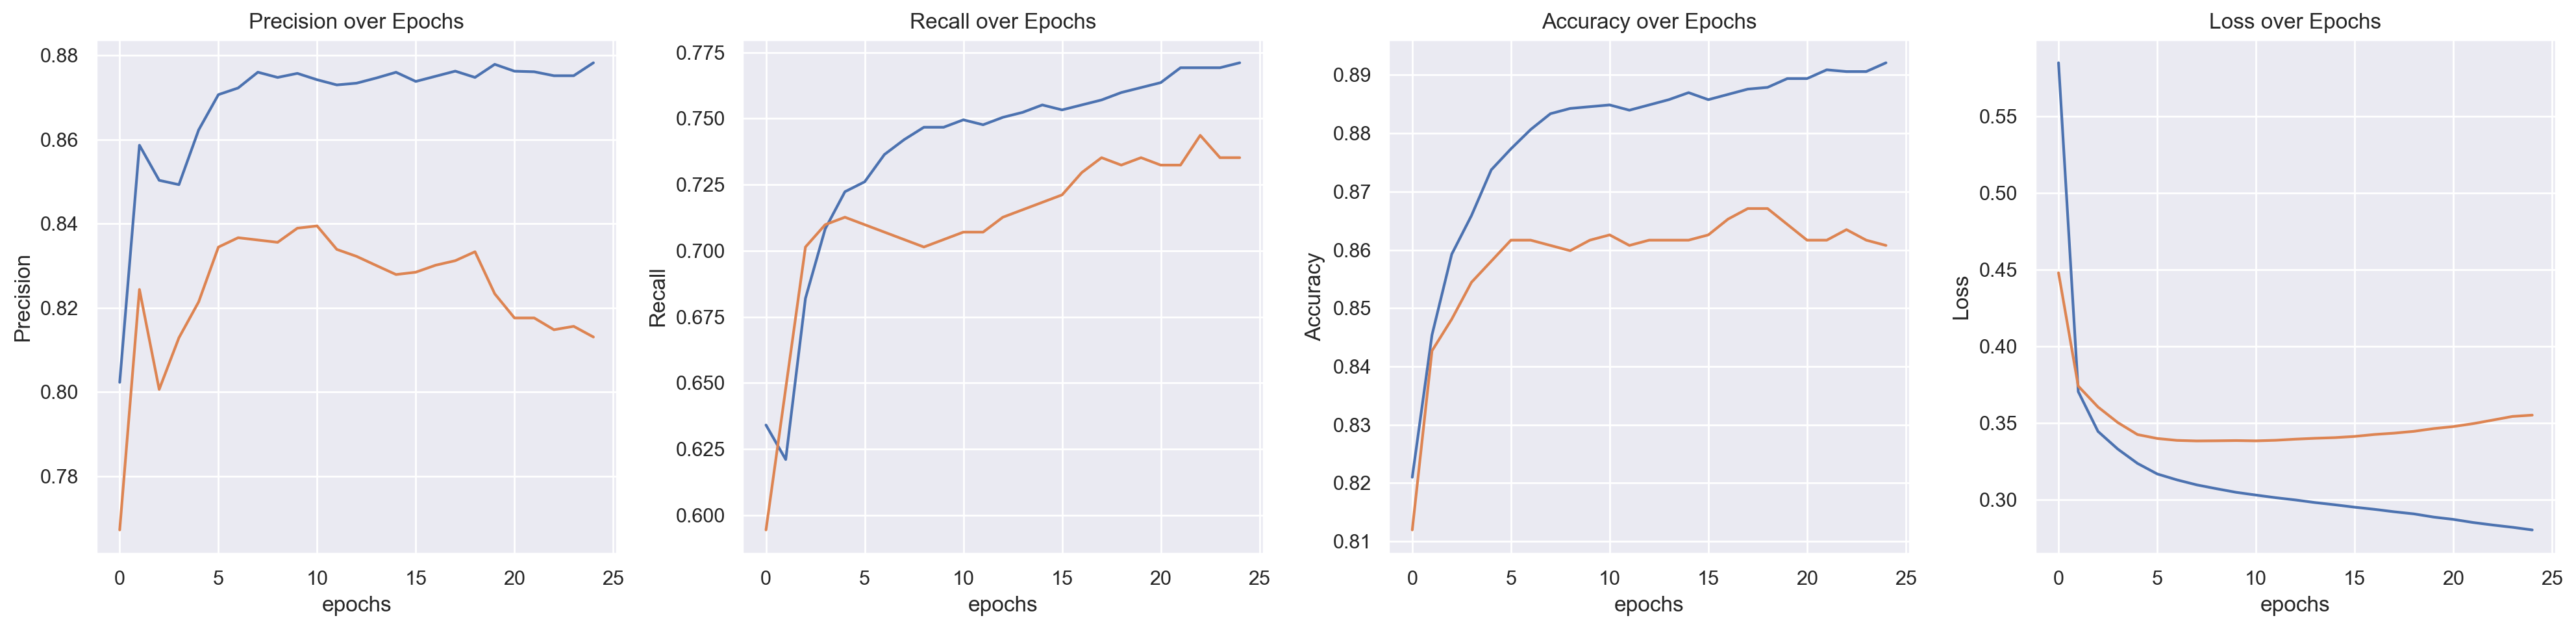

Average Precision: 0.8200
Average Recall: 0.7399


In [378]:
# Units controls the number of nodes in each layer.
units=[20,40,80,40,20,10]

%matplotlib inline
precision = 0
recall = 0

print("Model 1")
hist1, pred1, prec, reca = make_network(units, ds_train, ds_test, feature_space, 
                            numeric_headers, categorical_headers, wide_part=True)
precision += prec
recall += reca
plot_metrics(hist1)

print("Model 2")
hist2, pred2, prec, reca = make_network(units, ds_train2, ds_test2, feature_space, 
                            numeric_headers, categorical_headers, wide_part=True)
precision += prec
recall += reca
plot_metrics(hist2)

print("Model 3")
hist3, pred3, prec, reca = make_network(units, ds_train3, ds_test3, feature_space, 
                            numeric_headers, categorical_headers, wide_part=True)
precision += prec
recall += reca
plot_metrics(hist3)

print(f"Average Precision: {(precision / 3):.4f}")
print(f"Average Recall: {(recall / 3):.4f}")

### 2.6: Comparing the Performance of Different Models

Use statistical methods to compare the performance (average precision and average recall) of different models. Probably use McNemar Test. Not sure how to do it, I outputted the predictions for each model in the above cells if you need it.

### 2.7: Comparing to the MLP

In [ ]:
# Units controls the number of nodes in each layer.
units= """Find the best model from above"""

%matplotlib inline
precision = 0
recall = 0

print("Model 1")
hist1, pred1, prec, reca = make_network(units, ds_train, ds_test, feature_space, 
                            numeric_headers, categorical_headers, wide_part=False)
precision += prec
recall += reca
plot_metrics(hist1)

print("Model 2")
hist2, pred2, prec, reca = make_network(units, ds_train2, ds_test2, feature_space, 
                            numeric_headers, categorical_headers, wide_part=False)
precision += prec
recall += reca
plot_metrics(hist2)

print("Model 3")
hist3, pred3, prec, reca = make_network(units, ds_train3, ds_test3, feature_space, 
                            numeric_headers, categorical_headers, wide_part=False)
precision += prec
recall += reca
plot_metrics(hist3)

print(f"Average Precision: {(precision / 3):.4f}")
print(f"Average Recall: {(recall / 3):.4f}")

the output of the model (unrounded) will be the probabilities we need to feed into the roc_curve function. 1. Use the precision and recall, then determine statistical significance. 2. Then compare the ROC's of each model if they are not statistically significant.  Find the combination of True Positive Rates and False Positive Rates that works for our business case.